<font face="黑体" color=red size=6>负载图</font>

In [1]:
import os
import math
import torch
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from omnisafe.typing import Box
from SmartMeter_env_1 import SmartMeterEnv1
from omnisafe.models.actor.actor_builder import ActorBuilder

def map_range(value, from_min, from_max, to_min, to_max):
    normalized_value = (value - from_min) / (from_max - from_min)
    mapped_value = normalized_value * (to_max - to_min) + to_min
    return mapped_value

Device set to : cpu
Device set to : cpu


In [8]:
#dir_path = 'seed-001-2024-09-30-02-54-46'

# Load the trained model
LOG_DIR = '/runs/'+ dir_path
model_path = os.path.join(LOG_DIR, 'torch_save', 'epoch-3000.pt')

========reset=========
GaussianLearningActor(
  (mean): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Identity()
  )
)
当前日期: 82
初始电池电量: 0
720


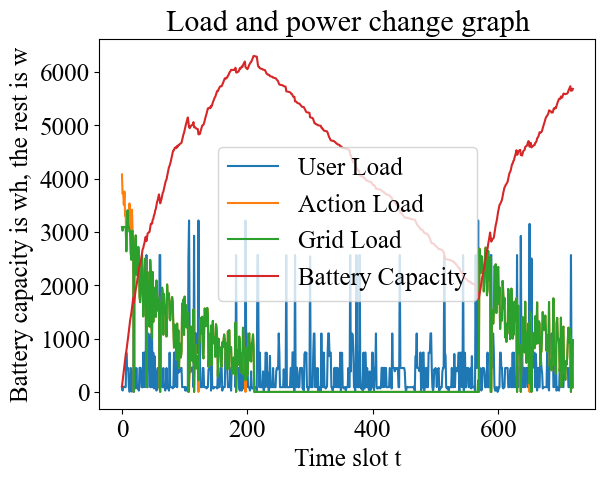

In [9]:
# set seed
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

actor_builder = ActorBuilder(
    obs_space=Box(low=-1, high=10000, shape=(3,)),
    act_space=Box(0, 1),
    hidden_sizes=[64, 64],
    activation='tanh',
    weight_initialization_mode='kaiming_uniform',
)
model = actor_builder.build_actor('gaussian_learning')
model.load_state_dict(torch.load(model_path)['pi'])

# Initialize environment and set to test mode
env = SmartMeterEnv1('SmartMeter1-v0')
obs = env.reset(test=True)[0]

hour = math.floor(env.time / 3600) 
min = math.floor((env.time - hour * 3600) / 60)
second = env.time % 60
start_time = datetime(2000, 6, 8, hour, min, second)

usr = []          # User load
grid = []         # Grid load
currentC = []     # Battery charge
actions = []      # Action load
chronology = []   # Chronology
actual_costs = 0  # Actual cost
shaping_costs = 0 # Shaping cost

# Print models and test information
print(model)
print("current date:", env.day)
print("Initial Battery Level:", env.currentC)

while True:
    action = model.predict(obs)
    action = map_range(action, -1, 1, 0, 1)
    usr.append(env.Usr)
    actual_costs += env.sample * env.Usr * env.price[env.price_tag] / (1000 * 3600)
    obs, rewards, costs, terminated, _, info = env.step(action)
    grid.append(env.Grid)
    shaping_costs += env.sample * env.Grid * env.price[env.price_tag] / (1000 * 3600)
    currentC.append(env.currentC)
    actions.append(env.action)
    if terminated:
        break

print(len(grid))

plt.plot(usr, label='User Load')
plt.plot(actions, label='Action Load')
plt.plot(grid, label='Grid Load')
plt.plot(currentC, label='Battery Capacity')
plt.legend()
plt.title('Load and power change graph')
plt.xlabel('Time slot t')
plt.ylabel('Battery capacity is wh, the rest is w')
plt.show()

actual_costs is  1.3142358027768861
shaping_costs is  1.5581624805372838
cost saving is  0.9894961674989984


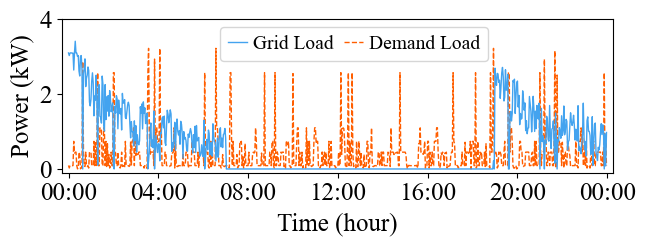

In [10]:
picdir = 'result.pdf'
save_path = 'C:/result'+ picdir
chronology = [start_time + timedelta(minutes=2 * i) for i in range(len(grid))]
nearest_hour_time = [start_time.replace(minute=0, second=0) + timedelta(hours=4 * i) for i in range(7)]
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.figure(figsize=(6.8, 2.8))
plt.xlabel('Time (hour)')
plt.ylabel('Power (kW)')
plt.plot(chronology, [g/1000 for g in grid], label="Grid Load", linewidth=1, zorder=2, color='#43a3ef')
plt.plot(chronology, [u/1000 for u in usr], linestyle='--', label="Demand Load", linewidth=1, zorder=1, color='#ff5e00')
plt.ylim(ymax = 4, ymin=-0.1)
hour_gap = 0.3
plt.xlim(left=chronology[0] - timedelta(hours=hour_gap), right=chronology[-1] + timedelta(hours=hour_gap))
plt.xticks(nearest_hour_time, [time.strftime('%H:%M') for time in nearest_hour_time], rotation=0)
plt.tight_layout()
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.53, 1.01), fontsize=14,handletextpad=0.3, handlelength=1,columnspacing=0.5)
plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=800)
print("actual_costs is ", actual_costs)
print("shaping_costs is ", shaping_costs)
print("cost saving is ", shaping_costs - currentC[-1]*0.0001)